In [95]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

from sklearn.model_selection import train_test_split

In [96]:
"""
Load data from files
"""

# load data from multiple Bearbeitungen
base_paths = ['./sensitive_data/machine_data/Bearbeitung_03',
'./sensitive_data/machine_data/Bearbeitung_04',
'./sensitive_data/machine_data/Bearbeitung_10']

data = []
for i, base_path in enumerate(base_paths):
    for f in os.listdir(base_path):
        idx = int(re.search("_([0-9]+)\.csv", f).group(1))
        d = pd.read_csv(os.path.join(base_path, f), parse_dates=["TimeStamp"])
        d["bauteil_idx"] = idx
        d["bearbeitung_idx"] = i
        d.set_index(["bearbeitung_idx", "bauteil_idx", "TimeStamp"], inplace=True)
        data.append(d)
data = pd.concat(data).sort_index()

In [97]:
"""
Combine data over each operation to get means and variances
"""

# get statistical aggregates of spin and z torques
mean = data.groupby(level=[0,1]).mean()[["FastNc_axis_SP1_AxTorqueAct","FastNc_axis_Z1_AxTorqueAct"]]
variance = data.groupby(level=[0,1]).var()[["FastNc_axis_SP1_AxTorqueAct","FastNc_axis_Z1_AxTorqueAct"]]
# rename columns
mean.rename(columns={"FastNc_axis_SP1_AxTorqueAct" : "SP_mean_0", "FastNc_axis_Z1_AxTorqueAct" : "Z_mean_0"}, inplace=True)
variance.rename(columns={"FastNc_axis_SP1_AxTorqueAct" : "SP_variance_0", "FastNc_axis_Z1_AxTorqueAct" : "Z_variance_0"}, inplace=True)
# combine dataframe
aggregate_data = pd.concat([mean, variance], axis=1)
# apply min-max scaling
min_scaling = aggregate_data.min()
max_scaling = aggregate_data.max()
aggregate_data = (aggregate_data - min_scaling)/(max_scaling - min_scaling)

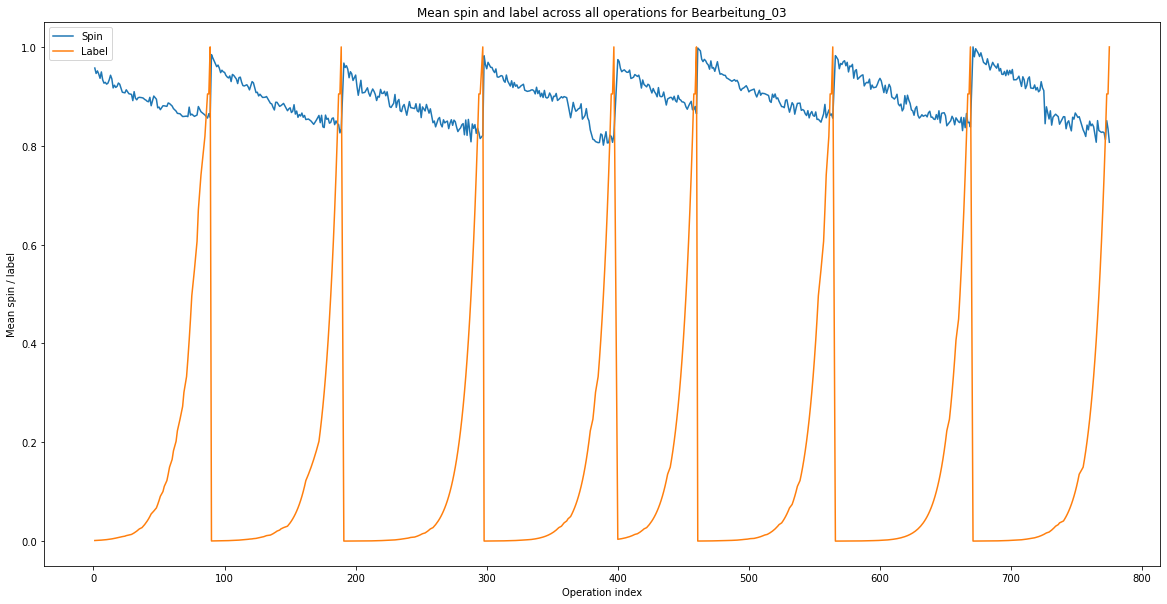

In [98]:
"""
Label training data

For labelling, make assumption that tool changes in the data happened when they became necessary due to tool properties (and not just following some fixed schedule / depend on other outside circumstances)
Can either treat this as a classification problem (e.g. decide after each operation if tool belongs to one of a few discrete classes) or continous task (e.g. infer some number which is related to degradation)

Classification:
Choose positive intergers n0, n1 with n1>n0 and define three categories:
    The last n0 operations before a tool change will be labelled (0), "change imminent"
    The n1 preceding these will be labelled (1), "change soon"
    All remaining datapoints will be labelled (2), "no change"

Continous:
Apply as label exp(-a * x), where x is the distance (in number of operations) to the next future tool change and a is a scaling factor

Currently using continous, lines for classification are commented out
"""

# define constants
n0 = 10
n1 = 20
a = 0.1
# identify ground truth (tool changes) via jumps in mean spin and set as new column
targets = -(aggregate_data["SP_mean_0"] - aggregate_data["SP_mean_0"].shift(-1))
mask = (targets > 0.1)
mask.loc[mask.index.get_level_values("bauteil_idx") == 800] = False # remove artifacts at last operation of each Bearbeitung
targets[~mask] = -1.0
targets[mask] = 0.0
labelled_data = aggregate_data.copy()
labelled_data["Target"] = targets
# drop data from each Bearbeitung after the last tool change
for bearbeitung_idx, bearbeitung in labelled_data.groupby(level=0):
    indices = list(labelled_data.loc[bearbeitung_idx].iloc[len(labelled_data.loc[bearbeitung_idx]) - (labelled_data.loc[bearbeitung_idx].Target.to_numpy() == 0.0)[::-1].argmax():].index.values)
    multi_indices = list(zip([bearbeitung_idx] * len(indices), indices))
    labelled_data.drop(multi_indices, inplace=True)
# calculate x
for bearbeitung_idx, bearbeitung in labelled_data.groupby(level=0):
    bearbeitung["Block"] = (bearbeitung["Target"] != bearbeitung["Target"].shift(-1)).astype(int).cumsum()
    labelled_data.loc[bearbeitung_idx, "Target"] = bearbeitung.groupby("Block").transform(lambda x: range(len(x), 0, -1))
# apply labels
# labelled_data.loc[labelled_data["Target"] <= n0, "Target"] = 0
# labelled_data.loc[(labelled_data["Target"] > n0) & (labelled_data["Target"] <= n0 + n1), "Target"] = 1
# labelled_data.loc[labelled_data["Target"] > n0 + n1, "Target"] = 2
labelled_data.loc[mask, "Target"] = 0.0
labelled_data["Target"] = np.exp(-a * labelled_data["Target"])
# visualise labels
plt.figure(figsize=(20,10))
plt.title("Mean spin and label across all operations for Bearbeitung_03")
plt.xlabel("Operation index")
plt.ylabel("Mean spin / label")
plt.plot(labelled_data.loc[0, "SP_mean_0"])
plt.plot(labelled_data.loc[0, "Target"])
plt.legend(["Spin", "Label"])
plt.show()

In [99]:
"""
Define custom dataset wrapper
"""

class CustomOperationDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [100]:
"""
Reshape data to include past operations and split into train/test
"""

t = 4 # amount of operations we take into account for each prediction
test_ratio = 0.2 # percentage of total data used as test set

# add columns for values of previous t-1 operations
raw_data = labelled_data.copy()
for i in range(1, t):
    raw_data["SP_mean_%i" %i] = raw_data["SP_mean_%i" %(i-1)].shift(1)
    raw_data["Z_mean_%i" %i] = raw_data["Z_mean_%i" %(i-1)].shift(1)
    raw_data["SP_variance_%i" %i] = raw_data["SP_variance_%i" %(i-1)].shift(1)
    raw_data["Z_variance_%i" %i] = raw_data["Z_variance_%i" %(i-1)].shift(1)
# drop first t-1 rows for each Bearbeitung
for bearbeitung_idx, bearbeitung in labelled_data.groupby(level=0):
    indices = range(1, t)
    multi_indices = list(zip([bearbeitung_idx] * len(indices), indices))
    raw_data.drop(multi_indices, inplace=True)
# squash multi-index down to single
raw_data = raw_data.reset_index().drop(["bearbeitung_idx", "bauteil_idx"], axis=1)
# split into data and labels
raw_labels = raw_data.pop("Target")
# split into train and test
# train_data, test_data, train_labels, test_labels = train_test_split(np.array(raw_data.values).astype(np.single), np.array(raw_labels.values).astype(np.int64), test_size=test_ratio, random_state=12345)
train_data, test_data, train_labels, test_labels = train_test_split(np.array(raw_data.values).astype(np.single), np.array(raw_labels.values).reshape(len(raw_data.values), 1).astype(np.single), test_size=test_ratio, random_state=12345)
# create dataloaders
train_dataset = CustomOperationDataset(train_data, train_labels)
test_dataset = CustomOperationDataset(test_data, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [101]:
"""
Create model
"""

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4 * t, 2 * t),
            nn.ReLU(),
            nn.Linear(2 * t, 1),
            # nn.Linear(2 * t, 3),
            # nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [102]:
"""
Define loss function and optimizer
"""
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [103]:
"""
Define training loop
"""

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [104]:
""" 
Define testing loop
"""

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    correct /= size
    print(f"Avg loss: {test_loss:>8f} \n")

In [105]:
"""
Train
"""

epochs = 15
for ep in range(epochs):
    print(f"Epoch {ep+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.034436  [    0/ 1615]
loss: 0.006517  [  400/ 1615]
loss: 0.427555  [  800/ 1615]
loss: 0.011718  [ 1200/ 1615]
loss: 0.012012  [ 1600/ 1615]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.043435 

Epoch 2
-------------------------------
loss: 0.011377  [    0/ 1615]
loss: 0.018436  [  400/ 1615]
loss: 0.014740  [  800/ 1615]
loss: 0.008944  [ 1200/ 1615]
loss: 0.013091  [ 1600/ 1615]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.042471 

Epoch 3
-------------------------------
loss: 0.010377  [    0/ 1615]
loss: 0.005561  [  400/ 1615]
loss: 0.012910  [  800/ 1615]
loss: 0.006879  [ 1200/ 1615]
loss: 0.000731  [ 1600/ 1615]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.041332 

Epoch 4
-------------------------------
loss: 0.005229  [    0/ 1615]
loss: 0.001676  [  400/ 1615]
loss: 0.068791  [  800/ 1615]
loss: 0.006071  [ 1200/ 1615]
loss: 0.023357  [ 1600/ 1615]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.040045 

Epoch 5
----------------------------

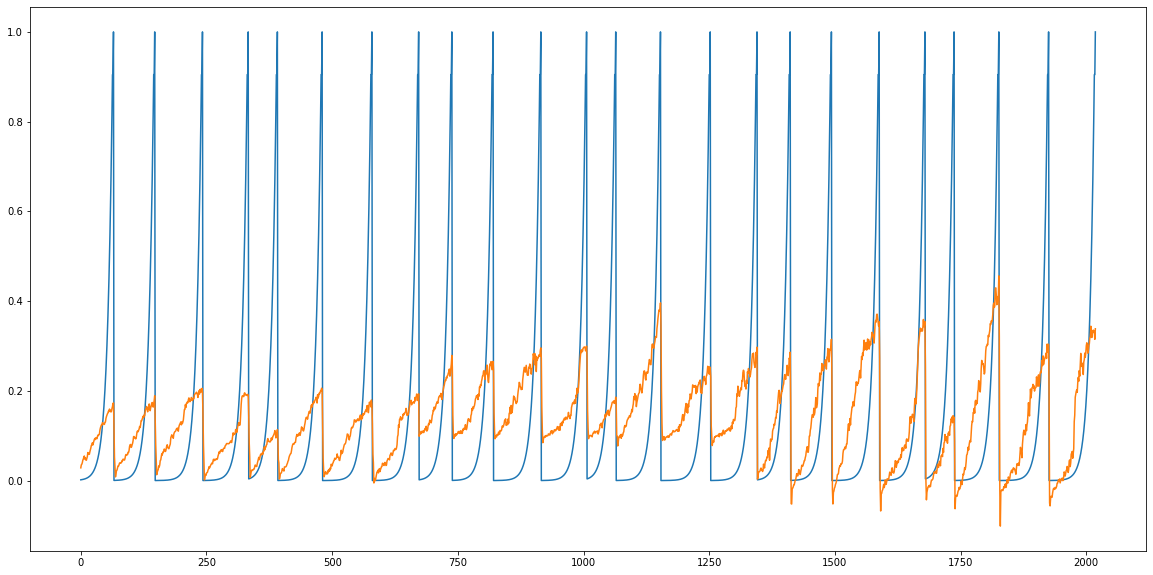

In [106]:
"""
Visualise predictions against labels
"""

predictions = model(torch.from_numpy(np.array(raw_data.values).astype(np.single)))
predictions = predictions.cpu().detach().numpy()

plt.figure(figsize=(20,10))
plt.plot(raw_labels)
#plt.plot(predictions.argmax(1))
plt.plot(predictions)
plt.show()

In [107]:
"""
Export model and print normalisation constants
"""

# set model to evaluation mode
model.eval()
# convert to torch script via tracing
example = torch.rand(1, 4 * t)
print(example)
print(model(example))
traced_script_module = torch.jit.trace(model, example)
# save
traced_script_module.save("traced_simple_nn.pt")
# show z-score normalisation values
print("SCALING MINS")
print(min_scaling)
print("SCALING MAXS")
print(max_scaling)

for p in model.parameters():
    print(p)

tensor([[0.1096, 0.8388, 0.0404, 0.8272, 0.3471, 0.3895, 0.7324, 0.1698, 0.5535,
         0.0546, 0.0754, 0.2403, 0.9556, 0.2976, 0.6651, 0.5877]])
tensor([[0.2642]], grad_fn=<AddmmBackward0>)
SCALING MINS
SP_mean_0       -21.690526
Z_mean_0          0.740429
SP_variance_0    37.316525
Z_variance_0      2.612419
dtype: float64
SCALING MAXS
SP_mean_0         -4.755163
Z_mean_0           7.189238
SP_variance_0    242.626806
Z_variance_0      37.999670
dtype: float64
Parameter containing:
tensor([[-0.0571, -0.1156, -0.0180,  0.0060,  0.1665,  0.0875, -0.1194,  0.0234,
         -0.0936, -0.1555,  0.1624,  0.1556, -0.2474, -0.0105, -0.1356,  0.1516],
        [-0.0738, -0.0509,  0.1216,  0.1234, -0.0761,  0.2446,  0.2372,  0.0885,
          0.2356,  0.1824, -0.1460,  0.1459,  0.2462,  0.0088,  0.1908, -0.0578],
        [ 0.0984,  0.0183, -0.0579, -0.1261, -0.2489, -0.1161, -0.0029, -0.0646,
          0.2022,  0.2476,  0.1266, -0.1138, -0.1596, -0.1550, -0.0446, -0.0217],
        [-0.2107,  0